# The Traveling Salesman using Reinforcement Learning

## Adaptive Computation and Machine Learning - Semester Project

### Student: M.Amine Boukrout
### Student No. 886515

In [1]:
import numpy as np
import pandas as pd
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import collections

Run the following block only if you need to change your working directory

In [2]:
import os
os.chdir('C:\\Users\Amine_Boukrout\Documents\Honors\Adaptive_Computation_and_Machine_Learning\Assignments\project_2018')

Choose the dataset to be used

In [3]:
datasets=['p01','att48']
filename=datasets[1]

The following function retrieves the matrix of cities, routes and the costs of traveling to the different cities

In [4]:
def TSPmatrixload(distFile,optrteFile):
    matrixR=pd.read_csv(distFile,header=None)
    matrixR=matrixR.as_matrix().astype('float32')
    dim=matrixR.shape[0]
    for i in range(0,dim):
        for j in range(0,dim):
            matrixR[i,j]=-1*matrixR[i,j]

    row=np.array([0]*dim)
    col=np.array([0]*(dim+1))
    matrixR=np.row_stack((matrixR,row))
    matrixR=np.column_stack((matrixR,col))

    for i in range(0,dim):
        matrixR[i,i]=np.nan

    matrixR[:,-1]=np.nan
    matrixR[:,-1]=np.nan
    matrixR[-1,1:-1]=np.nan
    optrtedf=pd.read_csv(optrteFile,header=None)
    optrtedf=optrtedf-1
    optimalroute=[]
    costOFTour=0
    for i in range(0,len(optrtedf)):
        optimalroute.append(optrtedf[0][i])
    for i in range(0,len(optimalroute)-1):
        fromnodw=optimalroute[i]
        tonode=optimalroute[i+1]
        tripcost=matrixR[fromnodw,tonode]
        costOFTour+-tripcost
    tourcost=abs(costOFTour)
    return matrixR,optimalroute,tourcost

In [5]:
distfile='tsp_matrices/'+filename+'_d.csv'
bestroutefile='tsp_matrices/'+filename+'_s.csv'

reward,bestroute,costofbestroute= TSPmatrixload(distfile,bestroutefile)

In [6]:
def epsilonGreedy(epsilon,s,Q,A):
    r=np.random.random_sample()
    if r>epsilon:
        max_Q=max(Q[s,A[:,0]])
        greedy_actions=[i for i,j in enumerate(Q[s,:]) if j==max_Q and i in A[:,0].tolist()]
        a=random.choice(greedy_actions)
    else: a=random.choice(A)[0]
    return a

In [7]:
def loadCoordenates(file_name_xy):
    coordenates=(pd.read_csv(file_name_xy,header=None))#*100000
    coordenates=coordenates.as_matrix().astype('float32')
    return coordenates

In [8]:
def qLearn(iters,rewint,start,alpha,gamma,epsilon,epsdecr,greward):
    transition_sequences=[]
    finalcost=[]
    Q=np.zeros_like(rewint)
    end=np.size(rewint,1)-1
    iter=0

    for i in range(0,iters):
        R=deepcopy(rewint)
        s=start
        visited=np.ones(np.size(R,1))
        transitions=0
        thecost=0
        goal=False
        z=0
        visited[s]=0
        transition_sequences.append([s])
        while (goal==False):
            R[0:-1,s]=np.nan
            A=np.argwhere(~np.isnan(R[s,:]))
            a=epsilonGreedy(epsilon,s,Q,A)

            transition_sequences[i].append(a)  # record transition made in current iteration
            snext=a
            availAct=np.argwhere(~np.isnan(R[snext,:]))

            # update Q matrix
            if (sum(visited)<3):
                update=Q[s,a]+alpha*((R[s,a]+gamma*Q[snext,4])-Q[s,a])
            else:
                update=Q[s,a]+alpha*((R[s,a]+gamma*max(Q[snext,availAct])[0])-Q[s,a])
            Q[s,a]=update
            thecost+=R[s,a]
            s=snext
            transitions+=1

            #updates
            visited[s]=0
            goal=(s==end)
            if ((sum(visited)==1 and z==0)):
                R[:,-1]=rewint[:,0]+greward
                R[:,0]=np.nan
                z+=1
            epsilon+=-epsdecr*epsilon

        thecost+=-greward
        finalcost.append(np.absolute(thecost))
        iter+=1
    return finalcost,transition_sequences,Q

The following block defines the required parameters for the Q-Learning Algorithm

In [9]:
iterationsNum=1000
start=0
rewardofgoal=100

# Define Q-Learning Parameters
alphas=np.array([0.1]).astype('float32')
gammas=np.array([1]).astype('float32')
epsilons=np.array([1]).astype('float32')
epsilondecr=np.array([0.3]).astype('float32')
numRuns=5

theSequences=[]
costsM=np.zeros((iterationsNum,numRuns))
costsAverage=np.zeros((iterationsNum,np.size(alphas)*np.size(gammas)*np.size(epsilons)*np.size(epsilondecr)))
loop_idx=0

The following block learns the optimal $n$ paths

In [10]:
# qlearning start
for a in range(0,np.size(alphas)):
    for g in range(0,np.size(gammas)):
        for e in range(0,np.size(epsilons)):
            for d in range(0,np.size(epsilondecr)):
                alpha=alphas[a]
                gamma=gammas[g]
                epsilon=epsilons[e]
                epsiDecr=epsilondecr[d]

                for runNo in range(0,numRuns):
                    costsOFIteration,trans_seqs,Q_matrix=\
                        qLearn(iterationsNum,reward,start,alpha,gamma,epsilon,epsiDecr,rewardofgoal)
                    #                    print(costsOFIteration)
                    for epoch in range(0,iterationsNum): theSequences.append(trans_seqs[epoch])
                    costsM[:,runNo]=costsOFIteration
                # ps_dic[loop_idx]=('A [%.2f],G [%.2f],E [%.2f],D [%.4f]' % (alpha,gamma,epsilon,epsilon_decay))
                costsAverage[:,loop_idx]=np.mean(costsM,1)
                loop_idx+=1

if costofbestroute==0 or costofbestroute==np.nan:
    costofbestroute=4
dataMap=costsAverage/costofbestroute

In [11]:
n=20
datAve=np.zeros_like(dataMap)
for k in range(0,int(np.size(dataMap,1))):
    for i in range(1,int(np.size(dataMap[:,k])+1)):
        if i<n-1: datAve[i-1,k]=(np.mean(dataMap[:,k][0:i]))
        else: datAve[i-1,k]=(np.mean(dataMap[:,k][i-(n-1):i]))

In [12]:
def QcovergencePlot(coord,var,title):
    fontAx={'color': 'black','weight': 500,'size': 16}
    plt.figure(figsize=(10,7))
    for i in range(0,int(np.size(var))): plt.plot(coord[:,i],label=str(var[i]))
#    plt.ylim(np.amax(coord)-40,np.amax(coord)+10)
    plt.grid(b=True,which='major',color='gray',linestyle='-')
    plt.xlabel('iterations',fontdict=fontAx)
    plt.ylabel('theCost)',fontdict=fontAx)
    plt.suptitle(str(title+': changes in Q value costs'),y=1,fontsize=20,style='normal',weight=500)
    plt.legend(loc='upper right',shadow=False,fontsize=16)
    plt.show()

In [13]:
xypathex='tsp_matrices/'+filename+'_xy.csv'
distCSV=pd.read_csv(xypathex)

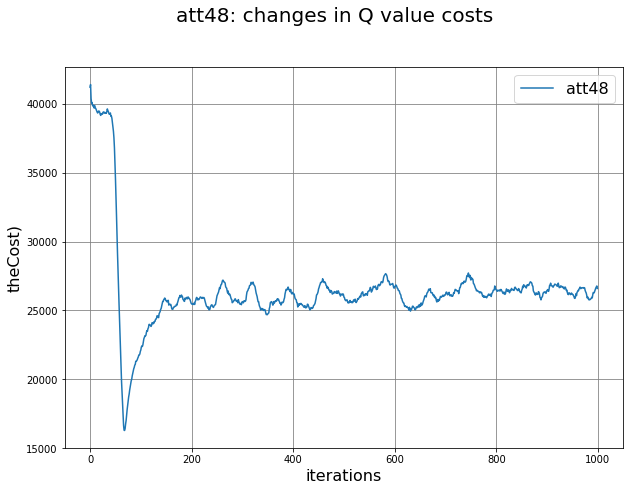

In [14]:
QcovergencePlot(datAve,[filename],filename)

In [15]:
def orderPaths(order,typ):
    for i in range(0,np.size(typ)):
        n=int(np.size(order,0)/np.size(typ))
        orderedict=collections.OrderedDict()
        for action in np.asarray(order)[i*n:(i*n)+n,:]:
            c=tuple(action)
          #  print('\n\n ordered paths:\n',t)
            if c in orderedict:
                orderedict[c]+=1
            else:
                orderedict[c]=1

        actSummary=[]
        for (key,val) in orderedict.items():
            actSummary.append(list(key)+[val])
        #print('trans\n',transition_summary)

        paths=np.asarray(actSummary).T
        idx=np.argsort(paths[-1,:])
        paths=paths[:,np.flipud(idx)]
        # print('paths\n',paths)
        return paths

The function in the previous plot orders the paths from optimal to least optimal. The oedering of paths is done in the block below.

It is import to note that the paths are stored in a 2D mmatrix, and that each column of the matrix represents a path. The optimal path is stored as the first column of the matrix, the second optimal path is is stored as the second column of the matrix, and so on.

In [16]:
paths=orderPaths(theSequences,[filename])

In [17]:
def plotSolution(cyCoord,titleData):
    fontA={'color': 'black','weight': 500,'size': 18}
    fontT={'color': 'black','weight': 500,'size': 22}
    fontNod={'family': 'fantasy','color': 'black','weight': 400,'size': 12}
    coordenates=loadCoordenates(cyCoord)
    coord=[]

    for i in range(0,np.size(titleData)):
        plt.figure(figsize=(17,13),facecolor='lightblue')
        ihg=[]
        plt.grid(b=False)
        plt.title(str(titleData[i]+' optimal path'),y=1.05,fontdict=fontT)
        plt.ylabel('latitude',fontdict=fontA)
        plt.xlabel('longitude',fontdict=fontA)
        plt.xticks([],[])
        plt.yticks([],[])

        thepath=np.asarray([coordenates[x,:] for x in paths[1:-1,0]])
        #print(path)
        for j in thepath[:,0]:
            if j not in ihg: ihg.append(j)
            #print(j)
        uyt=[]
        for u in thepath[:,1]:
            if u not in uyt: uyt.append(u)
            #print(u)
        plt.plot(ihg,uyt,linestyle='-',c='purple',alpha=0.2,linewidth=4,label='best path')
        for o in range(0,len(ihg)):
            coord.append([ihg[o],uyt[o]])
          #  print([ihg[o],uyt[o]])

        plt.legend(loc='upper left',shadow=False,fontsize=22)

        plt.scatter(coordenates[0:-1,0],coordenates[0:-1,1],
        c='blue',label='white',s=1000,alpha=0.5,edgecolors='whitesmoke',zorder=3)

        for j in range(0,np.size(coordenates,0)-1):
            plt.text(coordenates[j,0],coordenates[j,1],str(j),horizontalalignment='center',
                     verticalalignment='center',fontdict=fontNod)
        #    if [coordenates[j,0],coordenates[j,1]] in coord: print(coord[j],' in')
    #        dictindex[(coordenates[j,0],coordenates[j,1])]=coord.index([coordenates[j,0],coordenates[j,1]])
        plt.show()
        return thepath

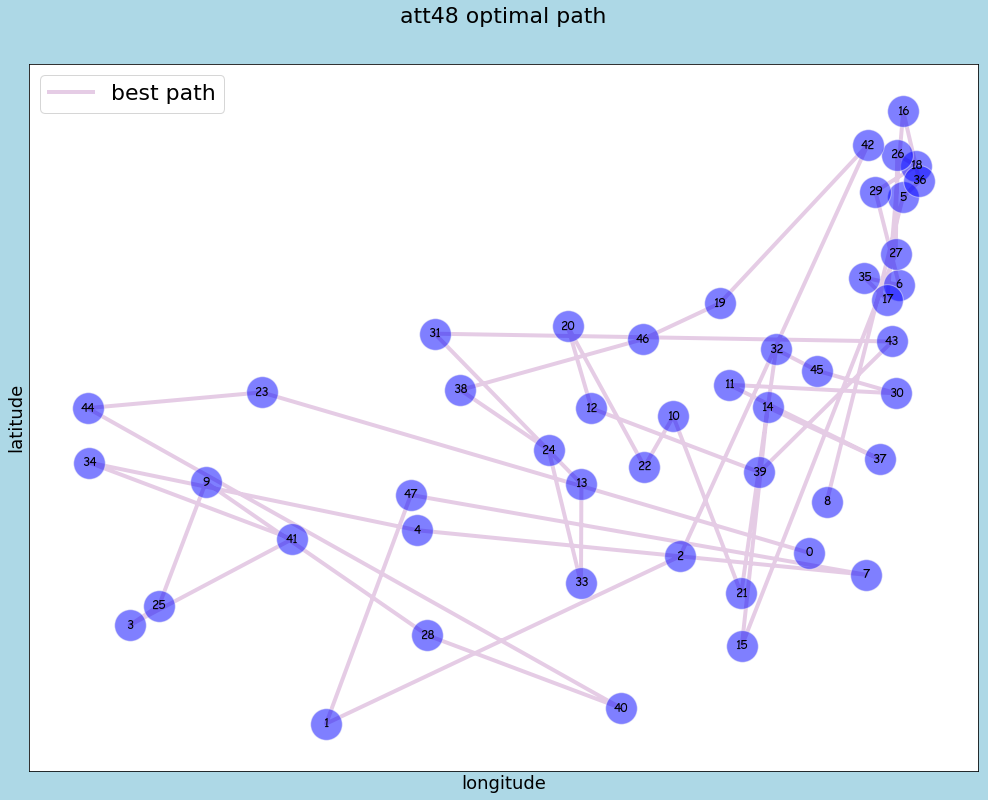

In [18]:
path=plotSolution(xypathex,[filename])

I tried plot arrows to display the paths, but I had problems doing so.

So I printed the path with the nodes numbers in the respective order.

In [19]:
print('the path is:')#,paths[1:-1,0])
for j in paths[1:-1,0]:
    if j==len(paths[1:-1,0]):
        print(0)
        break
    print(j,'--> ',end='')

the path is:
8 --> 5 --> 36 --> 16 --> 17 --> 35 --> 6 --> 29 --> 18 --> 26 --> 27 --> 15 --> 14 --> 37 --> 11 --> 30 --> 45 --> 32 --> 21 --> 10 --> 22 --> 20 --> 12 --> 39 --> 43 --> 31 --> 13 --> 33 --> 24 --> 38 --> 46 --> 19 --> 42 --> 2 --> 1 --> 47 --> 7 --> 4 --> 34 --> 41 --> 3 --> 25 --> 9 --> 28 --> 40 --> 44 --> 23 --> 0
